# Тюнинг гиперпараметров с помощью Optuna

В данной части я попытаюсь улучшить целевую метрику через Optuna (TPESampler + Hyperband Pruner). Качество исходных данных оставляет желать лучщего, сильнейший дизбаланс классов не даст нужной генерализации модели.

### 0. Импорты

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score, average_precision_score, precision_score, recall_score, f1_score, precision_recall_curve
import warnings
warnings.filterwarnings('ignore')
import joblib
import optuna
from scipy.signal import savgol_filter
import logging

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

### Загрузка данных и их подготовка

In [24]:
df = pd.read_csv('creditcard.csv')

df['log_amount'] = np.log1p(df['Amount'].clip(lower=0))
df['cos_time'] = np.cos(2 * np.pi * df['Time'] / (24 * 3600))
df.drop(['Time', 'Amount'], axis=1, inplace=True)

X = df.drop('Class', axis=1)
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scale_pos_weight = len(y_train[y_train==0]) / len(y_train[y_train==1])
print(f"Scale pos weight: {scale_pos_weight:.0f}")
print(f"Train shape: {X_train.shape}")
print(f"Test shape: {X_test.shape}")
print(f"Fraud ratio: {y_train.mean():.4f}")

Scale pos weight: 577
Train shape: (227845, 30)
Test shape: (56962, 30)
Fraud ratio: 0.0017


### Baseline из improvements

In [25]:
xgb_baseline = XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    eval_metric='aucpr',
    early_stopping_rounds=50,
    n_estimators=2000,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    verbosity=0
)

xgb_baseline.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=0)

y_pred_proba_baseline = xgb_baseline.predict_proba(X_test)[:, 1]
baseline_auprc = average_precision_score(y_test, y_pred_proba_baseline)
baseline_roc_auc = roc_auc_score(y_test, y_pred_proba_baseline)

print(f"Baseline AUPRC: {baseline_auprc:.4f}")
print(f"Baseline ROC-AUC: {baseline_roc_auc:.4f}")

Baseline AUPRC: 0.8803
Baseline ROC-AUC: 0.9747


### Optuna 
Поставил довольно широкие границы для гиперпараметров специально, т.к найти оптимум будет сложно

In [ ]:
def objective_optuna(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 2, 20),
        'learning_rate': trial.suggest_float('learning_rate', 0.0005, 0.7, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.6, 1.0),
        'colsample_bynode': trial.suggest_float('colsample_bynode', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 35),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 35),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 35),
        'gamma': trial.suggest_float('gamma', 0, 20),
        'max_delta_step': trial.suggest_int('max_delta_step', 0, 15),
    }
    
    model = XGBClassifier(
        scale_pos_weight=scale_pos_weight,
        random_state=42,
        eval_metric='aucpr',
        early_stopping_rounds=100,
        n_estimators=2000,
        **params,
        verbosity=0
    )
    

    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    cv_scores = []
    
    for fold, (train_idx, val_idx) in enumerate(cv.split(X_train, y_train)):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        model_fold = XGBClassifier(
            scale_pos_weight=scale_pos_weight,
            random_state=42 + fold,
            eval_metric='aucpr',
            early_stopping_rounds=100,
            n_estimators=2000,
            **params,
            verbosity=0
        )
        
        model_fold.fit(
            X_tr, y_tr,
            eval_set=[(X_val, y_val)],
            verbose=False
        )
        
        # Правильный pruning
        trial.report(model_fold.best_score, step=fold)
        
        if trial.should_prune():
            raise optuna.TrialPruned()
        
        y_pred_proba = model_fold.predict_proba(X_val)[:, 1]
        score = average_precision_score(y_val, y_pred_proba)
        cv_scores.append(score)
    
    return np.mean(cv_scores)

### Запускаем Optuna

TPESampler берет в данном случае 20 случайных значений, и в окрестностях лучших из них продолжает поиск оптимальных значений параметров. pruner просто экономит время на итерацию и заранее ее прекращает если метрики плохие.

In [ ]:
study = optuna.create_study(
    direction='maximize',
    sampler=optuna.samplers.TPESampler(seed=42, n_startup_trials=20, multivariate=True),
    pruner=optuna.pruners.HyperbandPruner(
        min_resource=1, max_resource=3, reduction_factor=3
    )
)


# Увеличиваем количество trials и время
study.optimize(objective_optuna, n_trials=300, timeout=14400, show_progress_bar=True)

print(f"Завершено trials: {len([t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE])}")
print(f"Прервано trials: {len([t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED])}")

if study.best_trial is None:
    raise ValueError("No trials completed successfully")

print(f"Лучшие параметры: {study.best_params}")
print(f"Лучший AUPRC: {study.best_value:.4f}")

Создаю финальную модель с найденными параметрами и обучаю на всех данных.

In [33]:
best_optuna_model = XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    eval_metric='aucpr',
    early_stopping_rounds=100,
    n_estimators=2000,
    **study.best_params,
    verbosity=1
)

best_optuna_model.fit(
    X_train, y_train, 
    eval_set=[(X_test, y_test)], 
    verbose=100
)


y_pred_proba_optuna = best_optuna_model.predict_proba(X_test)[:, 1]
optuna_auprc = average_precision_score(y_test, y_pred_proba_optuna)
optuna_roc_auc = roc_auc_score(y_test, y_pred_proba_optuna)

precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba_optuna)
f1_scores = 2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1] + 1e-8)

if len(f1_scores) > 11:
    f1_scores_smooth = savgol_filter(f1_scores, 11, 3)
else:
    f1_scores_smooth = f1_scores

optimal_idx = np.argmax(f1_scores_smooth)
optimal_threshold = thresholds[optimal_idx]

y_pred_optimal = (y_pred_proba_optuna >= optimal_threshold).astype(int)

precision_opt = precision_score(y_test, y_pred_optimal)
recall_opt = recall_score(y_test, y_pred_optimal)
f1_opt = f1_score(y_test, y_pred_optimal)

print(f"AUPRC: {optuna_auprc:.4f}")
print(f"ROC-AUC: {optuna_roc_auc:.4f}")
print(f"F1-Score: {f1_opt:.4f}")
print(f"Precision: {precision_opt:.4f}")
print(f"Recall: {recall_opt:.4f}")
print(f"Optimal threshold: {optimal_threshold:.4f}")

[0]	validation_0-aucpr:0.41484
[100]	validation_0-aucpr:0.85488
[200]	validation_0-aucpr:0.87154
[300]	validation_0-aucpr:0.87462
[400]	validation_0-aucpr:0.87561
[500]	validation_0-aucpr:0.87704
[600]	validation_0-aucpr:0.87775
[700]	validation_0-aucpr:0.87780
[754]	validation_0-aucpr:0.87804
AUPRC: 0.8784
ROC-AUC: 0.9742
F1-Score: 0.8556
Precision: 0.8989
Recall: 0.8163
Optimal threshold: 0.9219


In [36]:
improvement = optuna_auprc - baseline_auprc
improvement_pct = (improvement / baseline_auprc) * 100

print(f"Baseline AUPRC: {baseline_auprc:.4f}")
print(f"Optuna AUPRC:  {optuna_auprc:.4f}")
print(f"Улучшение:     {improvement:+.4f} ({improvement_pct:+.1f}%)")


train_proba_baseline = xgb_baseline.predict_proba(X_train)[:, 1]
train_proba_optuna = best_optuna_model.predict_proba(X_train)[:, 1]

train_auprc_baseline = average_precision_score(y_train, train_proba_baseline)
train_auprc_optuna = average_precision_score(y_train, train_proba_optuna)

overfitting_gap_baseline = train_auprc_baseline - baseline_auprc
overfitting_gap_optuna = train_auprc_optuna - optuna_auprc

print("Baseline:")
print(f"  Train AUPRC: {train_auprc_baseline:.4f}")
print(f"  Test AUPRC:  {baseline_auprc:.4f}")
print(f"  Gap: {overfitting_gap_baseline:.4f}")

print("Optuna:")
print(f"  Train AUPRC: {train_auprc_optuna:.4f}")
print(f"  Test AUPRC:  {optuna_auprc:.4f}")
print(f"  Gap: {overfitting_gap_optuna:.4f}")

train_test_gap = overfitting_gap_optuna

Baseline AUPRC: 0.8803
Optuna AUPRC:  0.8784
Улучшение:     -0.0018 (-0.2%)
Baseline:
  Train AUPRC: 1.0000
  Test AUPRC:  0.8803
  Gap: 0.1197
Optuna:
  Train AUPRC: 0.9990
  Test AUPRC:  0.8784
  Gap: 0.1205


Тюнинг не помог потому что бейзлайн уже был близок к максимуму для этого алгоритма. Я ссылаюсь на то, что при таком дизбалансе классов модель слишком сильно выучивает train выборку в любом случае, так как если не дать ей этого сделать, она будет показывать результаты и хуже. Исходное качество и количество данных влияют на генерализацию модели, ожидаю что shake up на других данных будет еще сильнее.

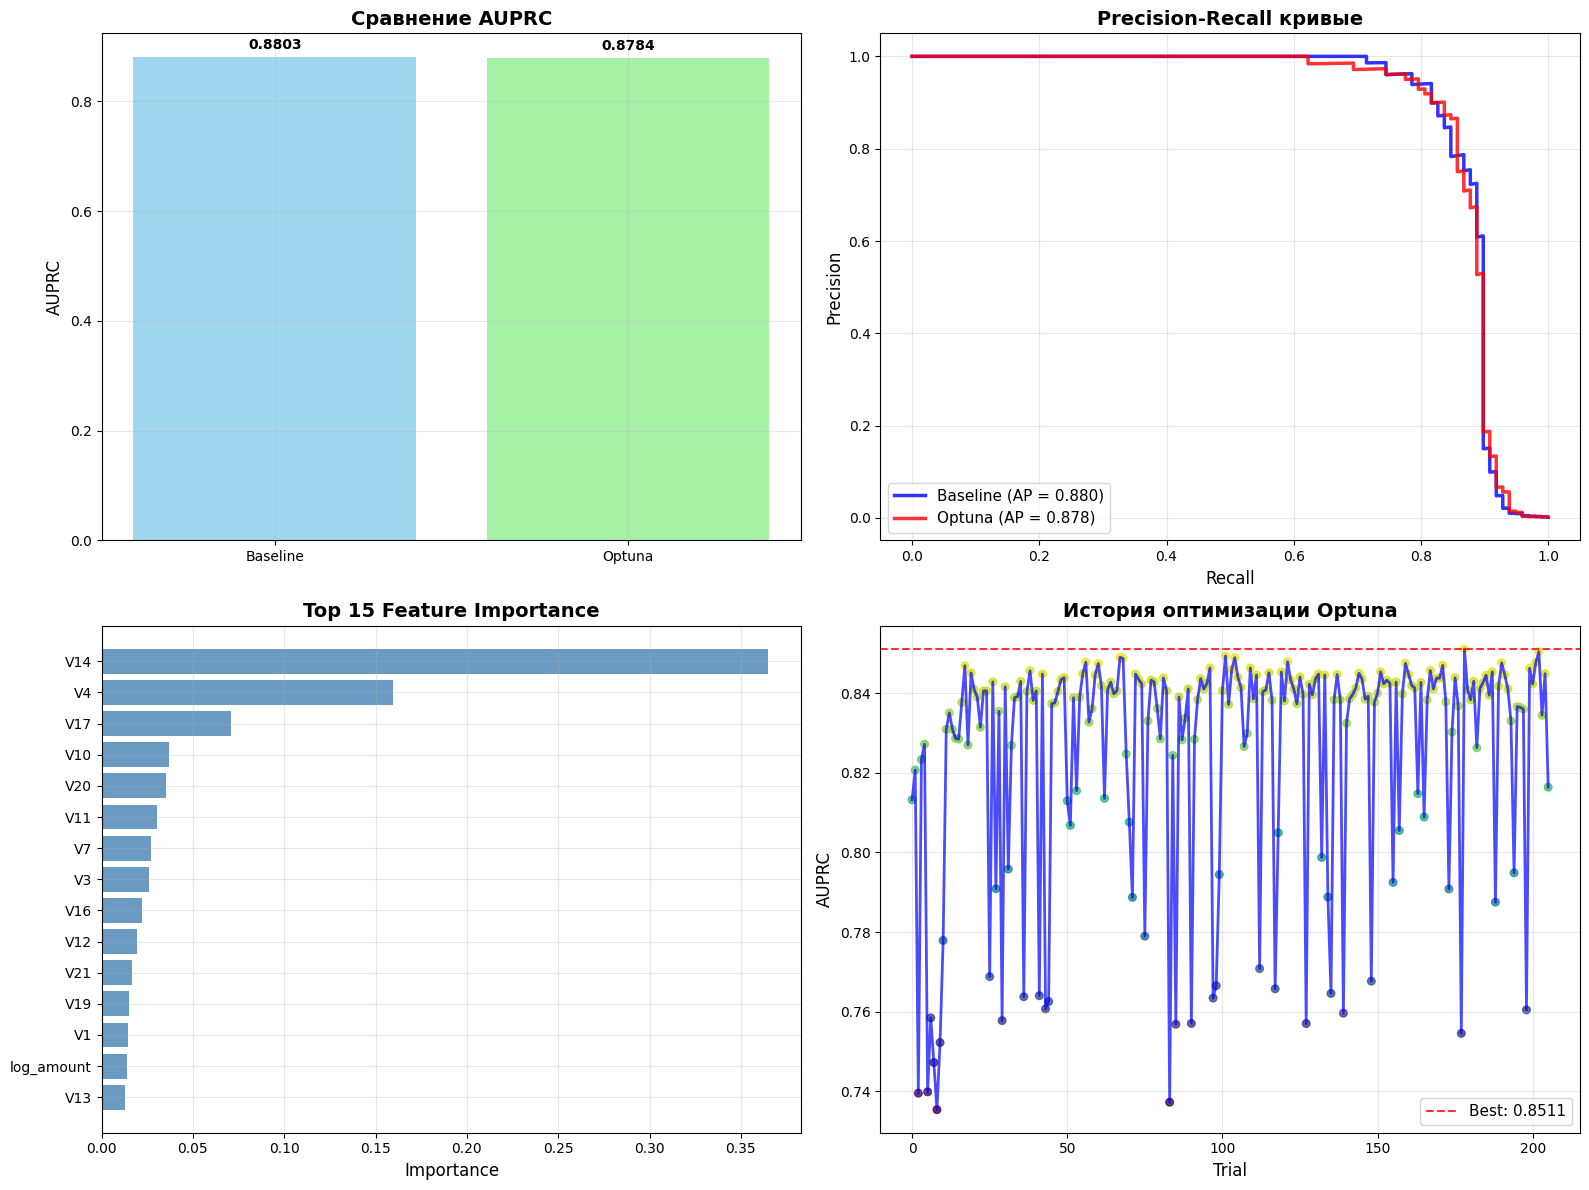

In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Сравнение AUPRC
models = ['Baseline', 'Optuna']
auprc_scores = [baseline_auprc, optuna_auprc]
colors = ['skyblue', 'lightgreen']
bars = ax1.bar(models, auprc_scores, color=colors, alpha=0.8)
ax1.set_title('Сравнение AUPRC', fontsize=14, fontweight='bold')
ax1.set_ylabel('AUPRC', fontsize=12)
ax1.grid(True, alpha=0.3)

for bar, score in zip(bars, auprc_scores):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{score:.4f}', ha='center', va='bottom', fontweight='bold')

# Precision-Recall кривые
for name, y_pred_proba, color in [('Baseline', y_pred_proba_baseline, 'blue'), 
                                   ('Optuna', y_pred_proba_optuna, 'red')]:
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    auprc = average_precision_score(y_test, y_pred_proba)
    ax2.plot(recall, precision, label=f'{name} (AP = {auprc:.3f})', 
             linewidth=2.5, color=color, alpha=0.8)
ax2.set_xlabel('Recall', fontsize=12)
ax2.set_ylabel('Precision', fontsize=12)
ax2.set_title('Precision-Recall кривые', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

importance = best_optuna_model.feature_importances_
feature_names = X_train.columns
importance_df = pd.DataFrame({'feature': feature_names, 'importance': importance})
importance_df = importance_df.sort_values('importance', ascending=True).tail(15)
ax3.barh(importance_df['feature'], importance_df['importance'], color='steelblue', alpha=0.8)
ax3.set_title('Top 15 Feature Importance', fontsize=14, fontweight='bold')
ax3.set_xlabel('Importance', fontsize=12)
ax3.grid(True, alpha=0.3)

if len(study.trials) > 0:
    completed_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]
    values = [t.value for t in completed_trials]
    ax4.plot(range(len(values)), values, 'b-', alpha=0.7, linewidth=2)
    ax4.scatter(range(len(values)), values, c=values, cmap='viridis', s=30, alpha=0.8)
    ax4.axhline(y=study.best_value, color='r', linestyle='--', alpha=0.8, 
                label=f'Best: {study.best_value:.4f}')
    ax4.set_xlabel('Trial', fontsize=12)
    ax4.set_ylabel('AUPRC', fontsize=12)
    ax4.set_title('История оптимизации Optuna', fontsize=14, fontweight='bold')
    ax4.legend(fontsize=11)
    ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()